## Data loading

In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

data_path = './cifar-10-batches-py/'

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_batch(file_path):
    with open(file_path, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = batch[b'labels']
        data = data.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
        return data, labels

def load_training_data(data_path):
    train_data = []
    train_labels = []
    for i in range(1, 6):
        data, labels = load_batch(data_path + f'data_batch_{i}')
        train_data.append(data)
        train_labels.extend(labels)

    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.array(train_labels)
    return train_data, train_labels

train_data, train_labels = load_training_data(data_path)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.1, random_state=42
)

print(f"Train dataset: {train_data.shape}, Validation dataset: {val_data.shape}")

def save_data(file_path, data, labels):
    with open(file_path, 'wb') as f:
        pickle.dump({'data': data, 'labels': labels}, f)

save_data('train_data.pkl', train_data, train_labels)

save_data('val_data.pkl', val_data, val_labels)




Train dataset: (45000, 32, 32, 3), Validation dataset: (5000, 32, 32, 3)


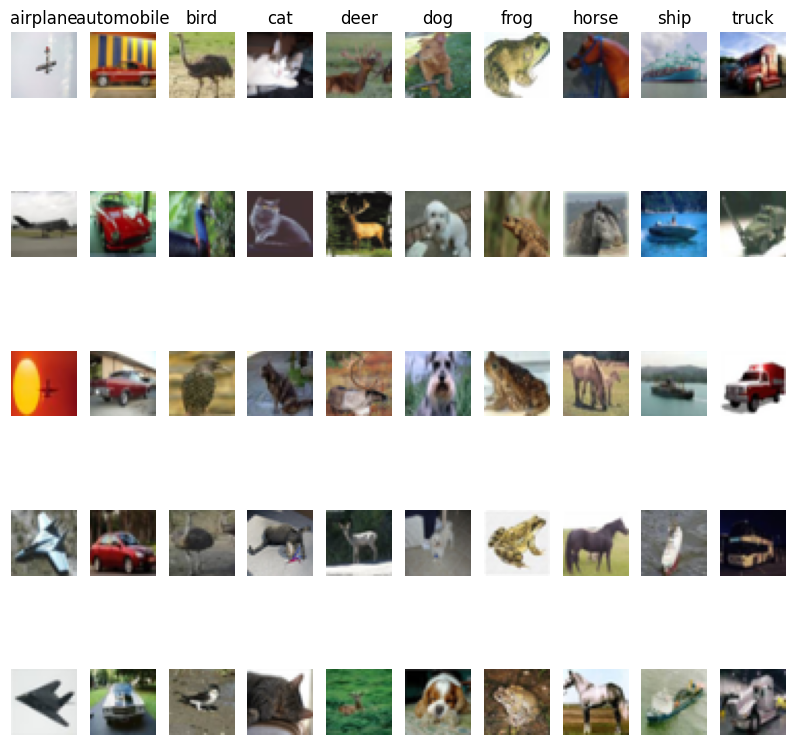

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

#Data preview

def preview_images(data, labels, class_names, samples_per_class=5):
    plt.figure(figsize=(10, 10))
    for class_id, class_name in enumerate(class_names):
    
        idxs = np.flatnonzero(labels == class_id)
       
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * len(class_names) + class_id + 1
            plt.subplot(samples_per_class, len(class_names), plt_idx)
            plt.imshow(data[idx])
            plt.axis('off')
            if i == 0:
                plt.title(class_name)
    plt.show()

preview_images(train_data, train_labels, class_names, samples_per_class=5)

In [ ]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CIFAR10Dataset(Dataset):
    def __init__(self, data_file, transform=None):
        with open(data_file, 'rb') as f:
            data_dict = pickle.load(f)
            self.data = data_dict['data']
            self.labels = data_dict['labels']
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        image = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0  
        if self.transform:
            image = self.transform(image)
        return image, label


transform = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))


train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


data_iter = iter(train_loader)
images, labels = next(data_iter)


print("Mean of each channel for a single image:", images[0].mean(dim=[1, 2]))  # 输出第一张图片每个通道的均值
print("Standard deviation of each channel for a single image:", images[0].std(dim=[1, 2]))  # 输出第一张图片每个通道的标准差

batch_mean = images.mean(dim=[0, 2, 3])  
batch_std = images.std(dim=[0, 2, 3])    
print("Mean of each channel for the batch of images:", batch_mean)
print("Standard deviation of each channel for the batch of images:", batch_std)


Mean of each channel for a single image: tensor([-0.4117, -0.5906, -0.4156])
Standard deviation of each channel for a single image: tensor([0.7546, 0.9046, 0.8541])
Mean of each channel for the batch of images: tensor([-0.0483, -0.0494, -0.0694])
Standard deviation of each channel for the batch of images: tensor([0.9679, 0.9736, 1.0024])


## Resnet-18

c:\Users\32987\OneDrive\文档\DLF\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\32987\OneDrive\文档\DLF\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 1.4115, Val Loss: 1.2485, Val Accuracy: 0.5702
Epoch 2/10, Train Loss: 1.0148, Val Loss: 0.9440, Val Accuracy: 0.6732
Epoch 3/10, Train Loss: 0.8338, Val Loss: 0.8181, Val Accuracy: 0.7124
Epoch 4/10, Train Loss: 0.7122, Val Loss: 0.8176, Val Accuracy: 0.7186
Epoch 5/10, Train Loss: 0.6140, Val Loss: 0.7478, Val Accuracy: 0.7406
Epoch 6/10, Train Loss: 0.5074, Val Loss: 0.7383, Val Accuracy: 0.7500
Epoch 7/10, Train Loss: 0.4284, Val Loss: 0.7970, Val Accuracy: 0.7446
Epoch 8/10, Train Loss: 0.3559, Val Loss: 0.7829, Val Accuracy: 0.7568
Epoch 9/10, Train Loss: 0.2874, Val Loss: 0.8225, Val Accuracy: 0.7564
Epoch 10/10, Train Loss: 0.2293, Val Loss: 0.8563, Val Accuracy: 0.7566


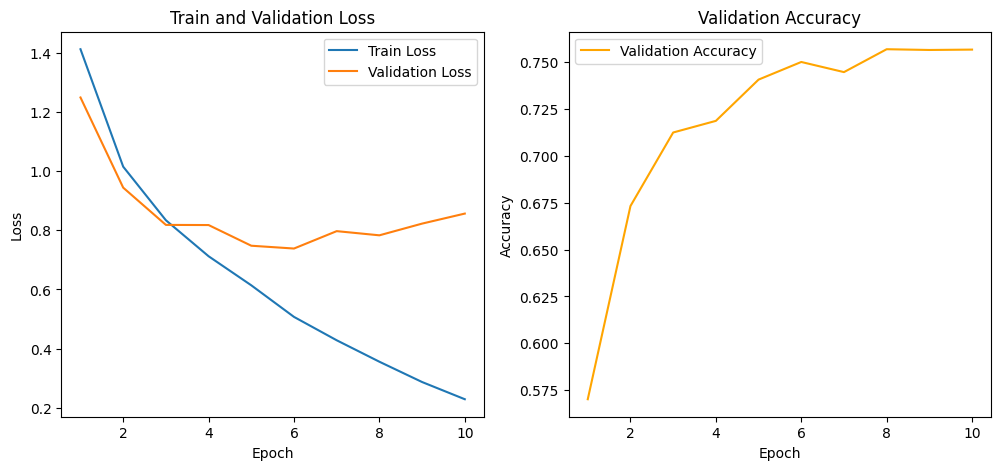

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt

train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ResNet-18
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy


for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


LR: 0.01, Optimizer: Adam, Epoch [1/10], Validation Accuracy: 0.5012
LR: 0.01, Optimizer: Adam, Epoch [2/10], Validation Accuracy: 0.6134
LR: 0.01, Optimizer: Adam, Epoch [3/10], Validation Accuracy: 0.6756
LR: 0.01, Optimizer: Adam, Epoch [4/10], Validation Accuracy: 0.7010
LR: 0.01, Optimizer: Adam, Epoch [5/10], Validation Accuracy: 0.7228
LR: 0.01, Optimizer: Adam, Epoch [6/10], Validation Accuracy: 0.7280
LR: 0.01, Optimizer: Adam, Epoch [7/10], Validation Accuracy: 0.7488
LR: 0.01, Optimizer: Adam, Epoch [8/10], Validation Accuracy: 0.7502
LR: 0.01, Optimizer: Adam, Epoch [9/10], Validation Accuracy: 0.7462
LR: 0.01, Optimizer: Adam, Epoch [10/10], Validation Accuracy: 0.7466
LR: 0.01, Optimizer: SGD, Epoch [1/10], Validation Accuracy: 0.5562
LR: 0.01, Optimizer: SGD, Epoch [2/10], Validation Accuracy: 0.5800
LR: 0.01, Optimizer: SGD, Epoch [3/10], Validation Accuracy: 0.6438
LR: 0.01, Optimizer: SGD, Epoch [4/10], Validation Accuracy: 0.6816
LR: 0.01, Optimizer: SGD, Epoch [5/10

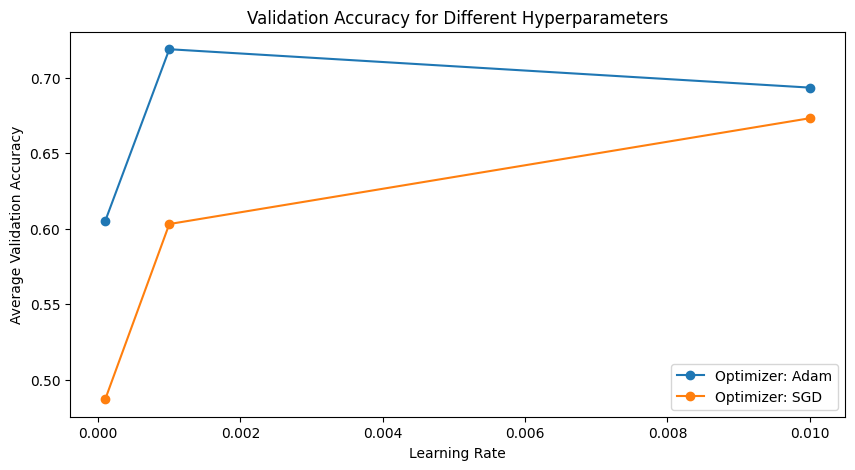

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt

train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

learning_rates = [0.01, 0.001, 0.0001]
optimizers = ['Adam', 'SGD']

best_val_accuracy = 0
best_params = None
results = []


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:
    for opt in optimizers:
    
        model = models.resnet18(pretrained=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)  
        model = model.to(device)

     
        criterion = nn.CrossEntropyLoss()
        if opt == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  
        num_epochs = 10
        val_accuracies = []
        
        for epoch in range(num_epochs):
           
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

         
            model.eval()
            correct = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = outputs.max(1)
                    correct += predicted.eq(labels).sum().item()
            val_accuracy = correct / len(val_loader.dataset)
            val_accuracies.append(val_accuracy)

            print(f"LR: {lr}, Optimizer: {opt}, Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}")

   
        avg_val_accuracy = sum(val_accuracies) / num_epochs
        results.append((lr, opt, avg_val_accuracy))
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_params = (lr, opt)


print("\nBest Validation Accuracy:", best_val_accuracy)
print("Best Hyperparameters - Learning Rate:", best_params[0], ", Optimizer:", best_params[1])


lrs, opts, accs = zip(*results)
plt.figure(figsize=(10, 5))
for optimizer in set(opts):
    plt.plot(
        [lr for lr, opt in zip(lrs, opts) if opt == optimizer],
        [acc for acc, opt in zip(accs, opts) if opt == optimizer],
        marker='o',
        label=f'Optimizer: {optimizer}'
    )
plt.xlabel("Learning Rate")
plt.ylabel("Average Validation Accuracy")
plt.legend()
plt.title("Validation Accuracy for Different Hyperparameters")
plt.show()


Epoch 1/20, Train Loss: 1.6754, Val Loss: 1.7937, Val Accuracy: 0.3990
Epoch 2/20, Train Loss: 1.2947, Val Loss: 1.2708, Val Accuracy: 0.5408
Epoch 3/20, Train Loss: 1.1167, Val Loss: 1.0666, Val Accuracy: 0.6334
Epoch 4/20, Train Loss: 1.0143, Val Loss: 1.0258, Val Accuracy: 0.6386
Epoch 5/20, Train Loss: 0.9261, Val Loss: 1.0368, Val Accuracy: 0.6318
Epoch 6/20, Train Loss: 0.8743, Val Loss: 0.8571, Val Accuracy: 0.7020
Epoch 7/20, Train Loss: 0.8154, Val Loss: 0.8104, Val Accuracy: 0.7186
Epoch 8/20, Train Loss: 0.7777, Val Loss: 0.8162, Val Accuracy: 0.7198
Epoch 9/20, Train Loss: 0.7468, Val Loss: 0.7557, Val Accuracy: 0.7408
Epoch 10/20, Train Loss: 0.7247, Val Loss: 0.8002, Val Accuracy: 0.7264
Epoch 11/20, Train Loss: 0.7034, Val Loss: 0.7435, Val Accuracy: 0.7396
Epoch 12/20, Train Loss: 0.6787, Val Loss: 0.7146, Val Accuracy: 0.7626
Epoch 13/20, Train Loss: 0.6578, Val Loss: 0.7226, Val Accuracy: 0.7546
Epoch 14/20, Train Loss: 0.6424, Val Loss: 0.6945, Val Accuracy: 0.7650
E

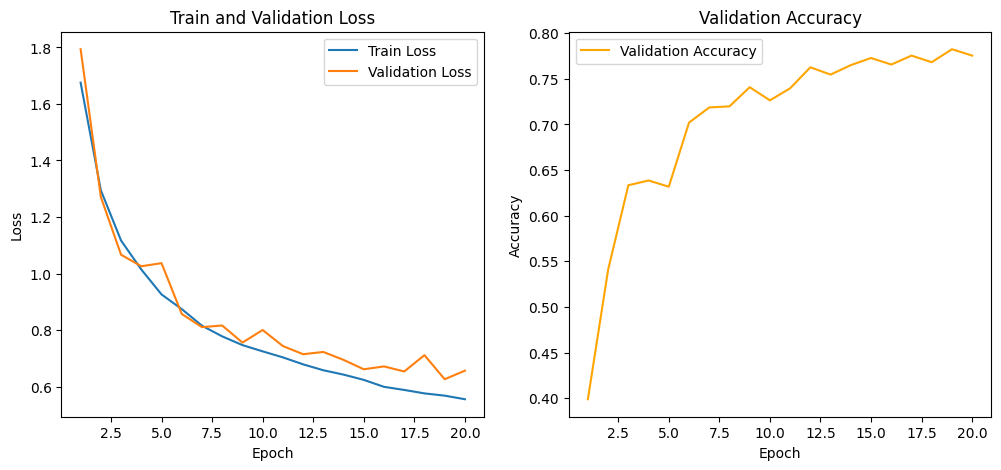

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


class ResNet18WithDropout(nn.Module):
    def __init__(self):
        super(ResNet18WithDropout, self).__init__()
        self.model = models.resnet18(pretrained=False)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  
            nn.Linear(num_features, 10)
        )
    
    def forward(self, x):
        return self.model(x)


model = ResNet18WithDropout()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # 添加权重衰减


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy


num_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Train Loss: 1.5308, Train Accuracy: 0.4629, Val Loss: 1.0694, Val Accuracy: 0.6237
Epoch [2/30], Train Loss: 1.0538, Train Accuracy: 0.6380, Val Loss: 0.9132, Val Accuracy: 0.6884
Epoch [3/30], Train Loss: 0.9122, Train Accuracy: 0.6888, Val Loss: 0.8250, Val Accuracy: 0.7150
Epoch [4/30], Train Loss: 0.8322, Train Accuracy: 0.7146, Val Loss: 0.7530, Val Accuracy: 0.7430
Epoch [5/30], Train Loss: 0.7807, Train Accuracy: 0.7322, Val Loss: 0.7351, Val Accuracy: 0.7457
Epoch [6/30], Train Loss: 0.7340, Train Accuracy: 0.7475, Val Loss: 0.7208, Val Accuracy: 0.7492
Epoch [7/30], Train Loss: 0.7050, Train Accuracy: 0.7588, Val Loss: 0.6904, Val Accuracy: 0.7596
Epoch [8/30], Train Loss: 0.6666, Train Accuracy: 0.7704, Val Loss: 0.6717, Val Accuracy: 0.7689
Epoch [9/30], Train Loss: 0.6469, Train Accuracy: 0.7778, Val Loss: 0.6587, Val Accuracy: 0.7770
Epoch [10/30], Train Loss: 0.6265, Train Accuracy: 

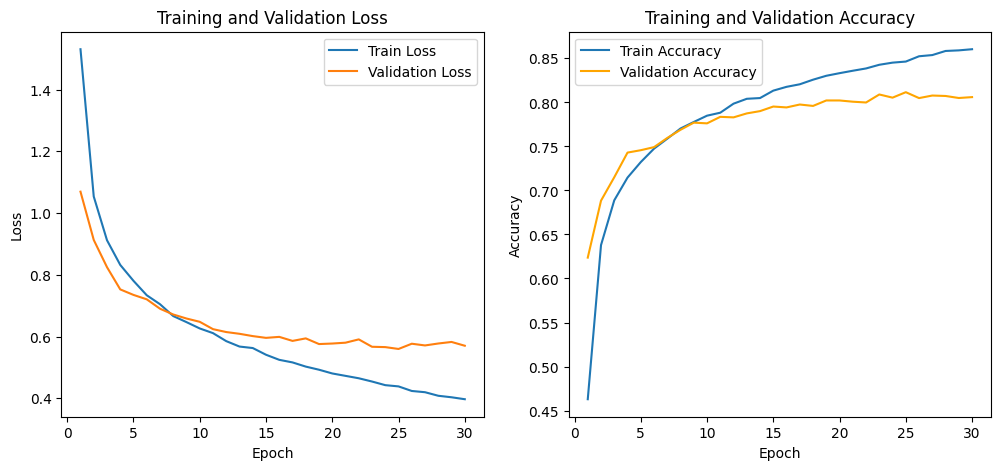

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class ResNet18WithDropout(nn.Module):
    def __init__(self):
        super(ResNet18WithDropout, self).__init__()
        self.model = models.resnet18(pretrained=True)  
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  
            nn.Linear(num_features, 10)
        )
    
    def forward(self, x):
        return self.model(x)

model = ResNet18WithDropout()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(train_loader.dataset)
    return total_loss / len(train_loader), accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy


num_epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []


for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

torch.save(model.state_dict(), 'final_resnet18_model.pth')

### MobileNet V2

Files already downloaded and verified
Epoch 1/20, Train Loss: 2.0943, Train Accuracy: 0.2232, Val Loss: 1.8744, Val Accuracy: 0.2962
Epoch 2/20, Train Loss: 1.8126, Train Accuracy: 0.3256, Val Loss: 1.7442, Val Accuracy: 0.3552
Epoch 3/20, Train Loss: 1.6927, Train Accuracy: 0.3766, Val Loss: 1.6346, Val Accuracy: 0.3856
Epoch 4/20, Train Loss: 1.6017, Train Accuracy: 0.4168, Val Loss: 1.5522, Val Accuracy: 0.4264
Epoch 5/20, Train Loss: 1.5111, Train Accuracy: 0.4522, Val Loss: 1.4634, Val Accuracy: 0.4732
Epoch 6/20, Train Loss: 1.4324, Train Accuracy: 0.4866, Val Loss: 1.3766, Val Accuracy: 0.5094
Epoch 7/20, Train Loss: 1.3605, Train Accuracy: 0.5139, Val Loss: 1.3581, Val Accuracy: 0.5108
Epoch 8/20, Train Loss: 1.3073, Train Accuracy: 0.5361, Val Loss: 1.2639, Val Accuracy: 0.5562
Epoch 9/20, Train Loss: 1.2511, Train Accuracy: 0.5562, Val Loss: 1.3080, Val Accuracy: 0.5404
Epoch 10/20, Train Loss: 1.2342, Train Accuracy: 0.5640, Val Loss: 1.2078, Val Accuracy: 0.5788
Epoch 11/20

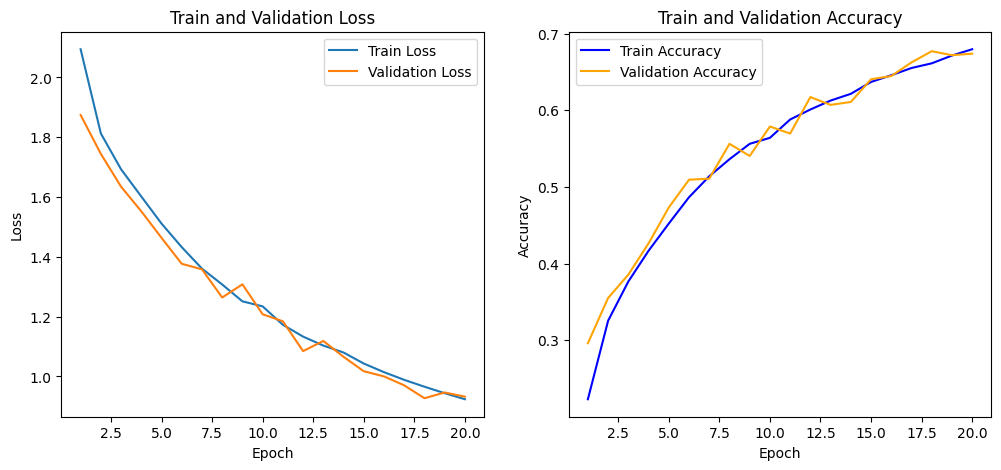

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class MobileNetV2Custom(nn.Module):
    def __init__(self):
        super(MobileNetV2Custom, self).__init__()
        self.model = models.mobilenet_v2(pretrained=False)
        
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 10)
        )
    
    def forward(self, x):
        return self.model(x)

model = MobileNetV2Custom()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # 使用 Adam 优化器，添加权重衰减


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
       
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        
    accuracy = correct / total
    return total_loss / len(train_loader), accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy


num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()


Files already downloaded and verified
Starting training with Learning Rate: 0.001 and Optimizer: <lambda>
Epoch 1/30, Train Loss: 2.1115, Train Accuracy: 0.2109, Val Loss: 1.8449, Val Accuracy: 0.3112
Epoch 2/30, Train Loss: 1.7915, Train Accuracy: 0.3341, Val Loss: 1.6994, Val Accuracy: 0.3714
Epoch 3/30, Train Loss: 1.6849, Train Accuracy: 0.3818, Val Loss: 1.5810, Val Accuracy: 0.4230
Epoch 4/30, Train Loss: 1.5941, Train Accuracy: 0.4191, Val Loss: 1.5017, Val Accuracy: 0.4532
Epoch 5/30, Train Loss: 1.5154, Train Accuracy: 0.4525, Val Loss: 1.4560, Val Accuracy: 0.4866
Epoch 6/30, Train Loss: 1.4327, Train Accuracy: 0.4857, Val Loss: 1.3942, Val Accuracy: 0.5084
Epoch 7/30, Train Loss: 1.3696, Train Accuracy: 0.5113, Val Loss: 1.3737, Val Accuracy: 0.5100
Epoch 8/30, Train Loss: 1.2957, Train Accuracy: 0.5409, Val Loss: 1.3101, Val Accuracy: 0.5382
Epoch 9/30, Train Loss: 1.2406, Train Accuracy: 0.5620, Val Loss: 1.1761, Val Accuracy: 0.5854
Epoch 10/30, Train Loss: 1.1842, Train 

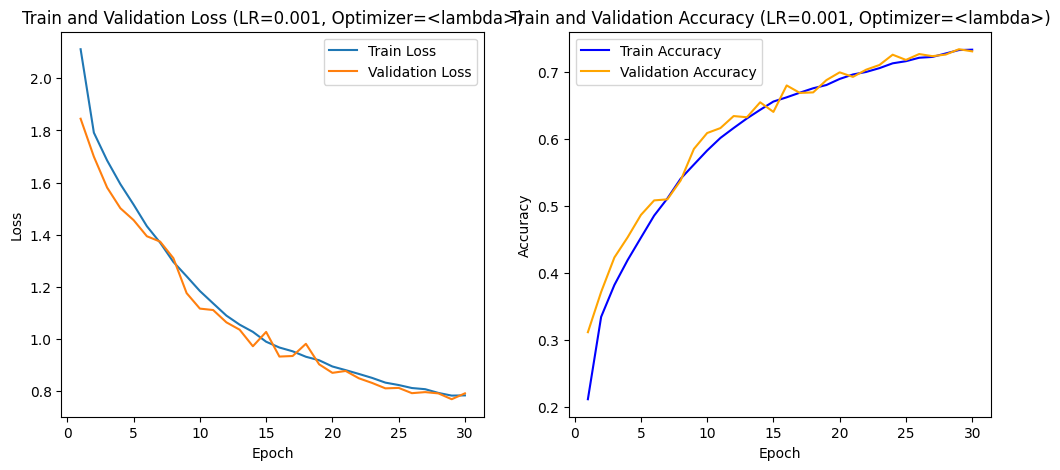

Starting training with Learning Rate: 0.001 and Optimizer: <lambda>
Epoch 1/30, Train Loss: 2.1474, Train Accuracy: 0.1878, Val Loss: 1.9583, Val Accuracy: 0.2546
Epoch 2/30, Train Loss: 1.9124, Train Accuracy: 0.2780, Val Loss: 1.8270, Val Accuracy: 0.3150
Epoch 3/30, Train Loss: 1.8204, Train Accuracy: 0.3169, Val Loss: 1.7593, Val Accuracy: 0.3486
Epoch 4/30, Train Loss: 1.7558, Train Accuracy: 0.3437, Val Loss: 1.6830, Val Accuracy: 0.3736
Epoch 5/30, Train Loss: 1.7055, Train Accuracy: 0.3672, Val Loss: 1.6425, Val Accuracy: 0.3888
Epoch 6/30, Train Loss: 1.6618, Train Accuracy: 0.3850, Val Loss: 1.6085, Val Accuracy: 0.4052
Epoch 7/30, Train Loss: 1.6235, Train Accuracy: 0.4012, Val Loss: 1.5788, Val Accuracy: 0.4228
Epoch 8/30, Train Loss: 1.5954, Train Accuracy: 0.4142, Val Loss: 1.5390, Val Accuracy: 0.4448
Epoch 9/30, Train Loss: 1.5686, Train Accuracy: 0.4274, Val Loss: 1.5047, Val Accuracy: 0.4514
Epoch 10/30, Train Loss: 1.5331, Train Accuracy: 0.4386, Val Loss: 1.4898, Va

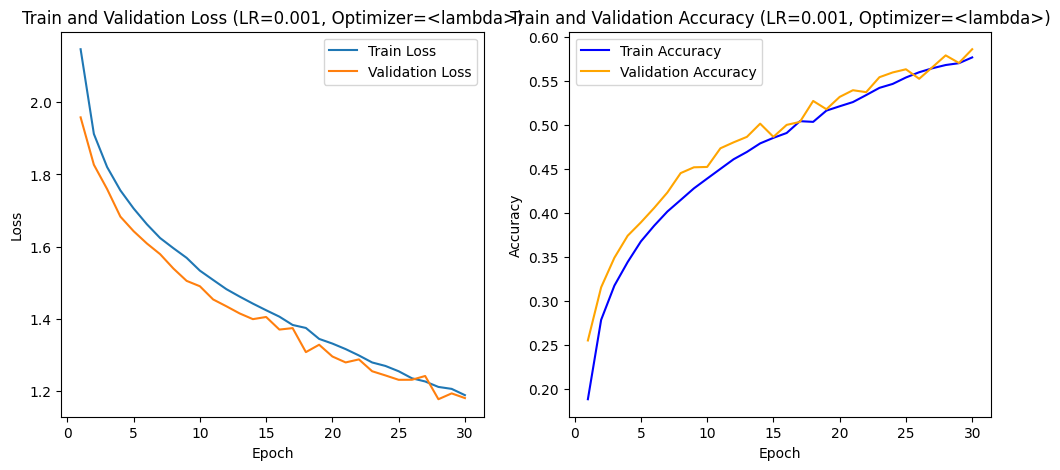

Starting training with Learning Rate: 0.0005 and Optimizer: <lambda>
Epoch 1/30, Train Loss: 2.1058, Train Accuracy: 0.2148, Val Loss: 1.8740, Val Accuracy: 0.2870
Epoch 2/30, Train Loss: 1.7988, Train Accuracy: 0.3326, Val Loss: 1.7131, Val Accuracy: 0.3580
Epoch 3/30, Train Loss: 1.6741, Train Accuracy: 0.3825, Val Loss: 1.5894, Val Accuracy: 0.4112
Epoch 4/30, Train Loss: 1.5762, Train Accuracy: 0.4246, Val Loss: 1.5170, Val Accuracy: 0.4610
Epoch 5/30, Train Loss: 1.4962, Train Accuracy: 0.4554, Val Loss: 1.4326, Val Accuracy: 0.4832
Epoch 6/30, Train Loss: 1.4246, Train Accuracy: 0.4888, Val Loss: 1.3854, Val Accuracy: 0.4930
Epoch 7/30, Train Loss: 1.3597, Train Accuracy: 0.5130, Val Loss: 1.3048, Val Accuracy: 0.5308
Epoch 8/30, Train Loss: 1.2928, Train Accuracy: 0.5378, Val Loss: 1.2683, Val Accuracy: 0.5570
Epoch 9/30, Train Loss: 1.2422, Train Accuracy: 0.5619, Val Loss: 1.2339, Val Accuracy: 0.5776
Epoch 10/30, Train Loss: 1.1869, Train Accuracy: 0.5800, Val Loss: 1.1323, V

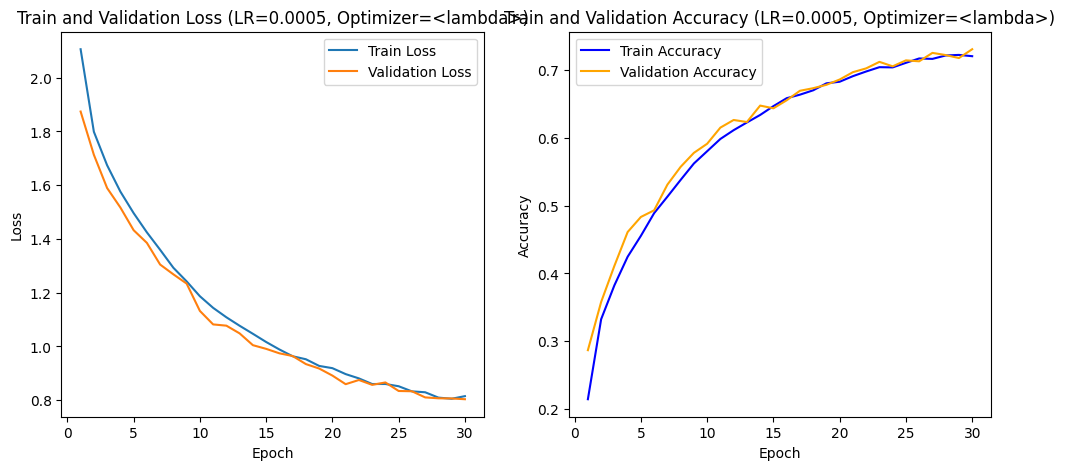

Starting training with Learning Rate: 0.0005 and Optimizer: <lambda>
Epoch 1/30, Train Loss: 2.1809, Train Accuracy: 0.1789, Val Loss: 1.9866, Val Accuracy: 0.2504
Epoch 2/30, Train Loss: 1.9336, Train Accuracy: 0.2756, Val Loss: 1.8263, Val Accuracy: 0.3124
Epoch 3/30, Train Loss: 1.8180, Train Accuracy: 0.3196, Val Loss: 1.7331, Val Accuracy: 0.3610
Epoch 4/30, Train Loss: 1.7409, Train Accuracy: 0.3566, Val Loss: 1.6720, Val Accuracy: 0.3868
Epoch 5/30, Train Loss: 1.6800, Train Accuracy: 0.3784, Val Loss: 1.6216, Val Accuracy: 0.4058
Epoch 6/30, Train Loss: 1.6309, Train Accuracy: 0.3987, Val Loss: 1.5844, Val Accuracy: 0.4198
Epoch 7/30, Train Loss: 1.5969, Train Accuracy: 0.4150, Val Loss: 1.5618, Val Accuracy: 0.4214
Epoch 8/30, Train Loss: 1.5645, Train Accuracy: 0.4297, Val Loss: 1.5082, Val Accuracy: 0.4490
Epoch 9/30, Train Loss: 1.5345, Train Accuracy: 0.4403, Val Loss: 1.4924, Val Accuracy: 0.4542
Epoch 10/30, Train Loss: 1.5131, Train Accuracy: 0.4467, Val Loss: 1.4637, V

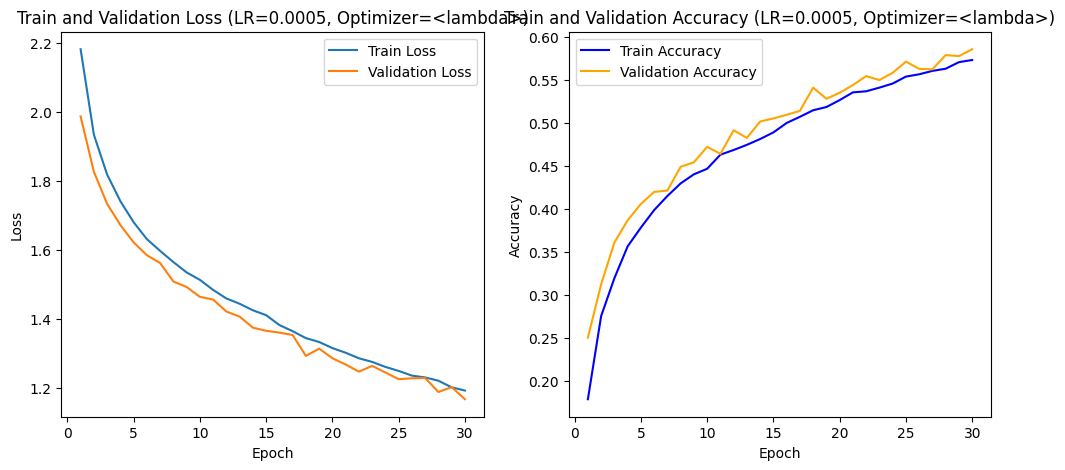

Starting training with Learning Rate: 0.0001 and Optimizer: <lambda>
Epoch 1/30, Train Loss: 2.1093, Train Accuracy: 0.2150, Val Loss: 1.8736, Val Accuracy: 0.3090
Epoch 2/30, Train Loss: 1.8150, Train Accuracy: 0.3274, Val Loss: 1.7432, Val Accuracy: 0.3554
Epoch 3/30, Train Loss: 1.6724, Train Accuracy: 0.3888, Val Loss: 1.6055, Val Accuracy: 0.4184
Epoch 4/30, Train Loss: 1.5688, Train Accuracy: 0.4282, Val Loss: 1.5359, Val Accuracy: 0.4390
Epoch 5/30, Train Loss: 1.4709, Train Accuracy: 0.4677, Val Loss: 1.4522, Val Accuracy: 0.4692
Epoch 6/30, Train Loss: 1.3994, Train Accuracy: 0.5000, Val Loss: 1.3172, Val Accuracy: 0.5264
Epoch 7/30, Train Loss: 1.3370, Train Accuracy: 0.5243, Val Loss: 1.2700, Val Accuracy: 0.5408
Epoch 8/30, Train Loss: 1.2799, Train Accuracy: 0.5472, Val Loss: 1.2290, Val Accuracy: 0.5714
Epoch 9/30, Train Loss: 1.2313, Train Accuracy: 0.5635, Val Loss: 1.1741, Val Accuracy: 0.5872
Epoch 10/30, Train Loss: 1.1883, Train Accuracy: 0.5816, Val Loss: 1.1593, V

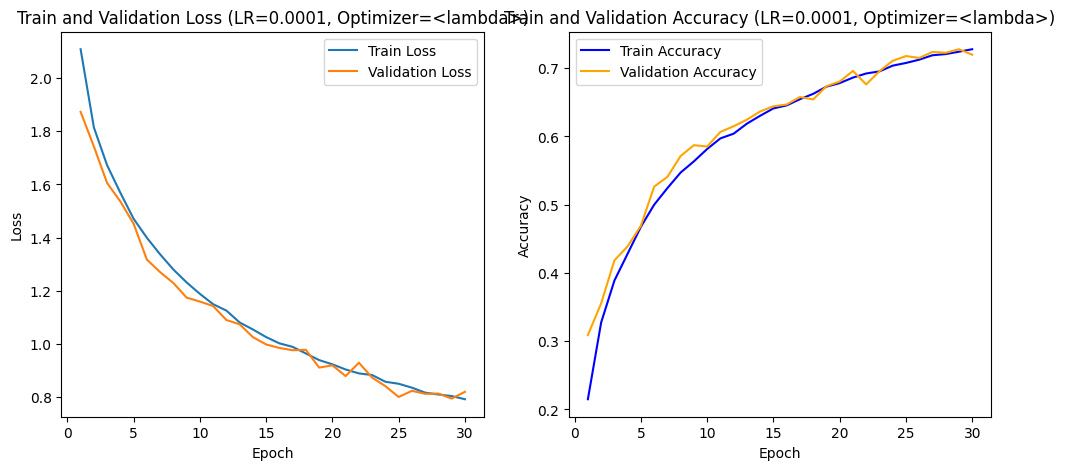

Starting training with Learning Rate: 0.0001 and Optimizer: <lambda>
Epoch 1/30, Train Loss: 2.1631, Train Accuracy: 0.1843, Val Loss: 1.9667, Val Accuracy: 0.2620
Epoch 2/30, Train Loss: 1.9326, Train Accuracy: 0.2726, Val Loss: 1.8254, Val Accuracy: 0.3222
Epoch 3/30, Train Loss: 1.8221, Train Accuracy: 0.3181, Val Loss: 1.7363, Val Accuracy: 0.3488
Epoch 4/30, Train Loss: 1.7501, Train Accuracy: 0.3502, Val Loss: 1.6616, Val Accuracy: 0.3904
Epoch 5/30, Train Loss: 1.6868, Train Accuracy: 0.3778, Val Loss: 1.6253, Val Accuracy: 0.4070
Epoch 6/30, Train Loss: 1.6403, Train Accuracy: 0.3958, Val Loss: 1.5745, Val Accuracy: 0.4318
Epoch 7/30, Train Loss: 1.5928, Train Accuracy: 0.4173, Val Loss: 1.5209, Val Accuracy: 0.4510
Epoch 8/30, Train Loss: 1.5653, Train Accuracy: 0.4312, Val Loss: 1.4920, Val Accuracy: 0.4582
Epoch 9/30, Train Loss: 1.5261, Train Accuracy: 0.4445, Val Loss: 1.4556, Val Accuracy: 0.4720
Epoch 10/30, Train Loss: 1.5016, Train Accuracy: 0.4548, Val Loss: 1.4542, V

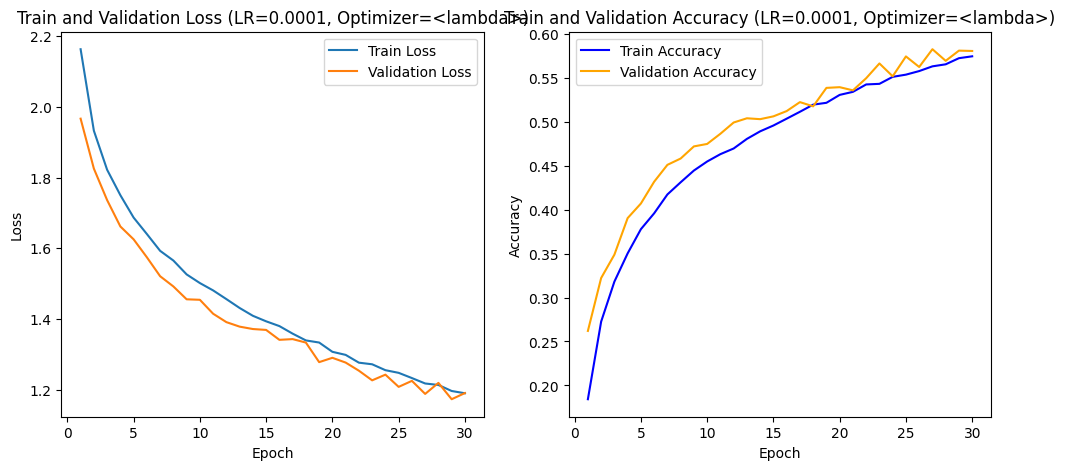

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class MobileNetV2Custom(nn.Module):
    def __init__(self):
        super(MobileNetV2Custom, self).__init__()
        self.model = models.mobilenet_v2(pretrained=False)
    
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 10)
        )
    
    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2Custom().to(device)


learning_rates = [0.001, 0.0005, 0.0001]
optimizers = [
    lambda params: optim.Adam(params, lr=0.001, weight_decay=0.0001),
    lambda params: optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0001)
]

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        
    accuracy = correct / total
    return total_loss / len(train_loader), accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy

num_epochs = 30


for lr in learning_rates:
    for optimizer_fn in optimizers:
    
        model = MobileNetV2Custom().to(device)
        optimizer = optimizer_fn(model.parameters())
        criterion = nn.CrossEntropyLoss()
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"Starting training with Learning Rate: {lr} and Optimizer: {optimizer_fn.__name__}")
        
      
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
            val_loss, val_accuracy = validate(model, val_loader, criterion, device)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
   
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Train and Validation Loss (LR={lr}, Optimizer={optimizer_fn.__name__})')

        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
        plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Train and Validation Accuracy (LR={lr}, Optimizer={optimizer_fn.__name__})')
        plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class MobileNetV2Custom(nn.Module):
    def __init__(self):
        super(MobileNetV2Custom, self).__init__()
        self.model = models.mobilenet_v2(pretrained=False)
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 10)
        )
    
    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        
    accuracy = correct / total
    return total_loss / len(train_loader), accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy


num_epochs = 30
early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0


learning_rate = 0.0005
optimizer = optim.Adam

model = MobileNetV2Custom().to(device)
optimizer = optimizer(model.parameters(), lr=learning_rate, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
   
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_mobilenet_model.pth')  
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered. Stopping training.")
        break


Files already downloaded and verified


c:\Users\32987\OneDrive\文档\DLF\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/30, Train Loss: 2.1753, Train Accuracy: 0.1869, Val Loss: 1.9733, Val Accuracy: 0.2694
Epoch 2/30, Train Loss: 1.9035, Train Accuracy: 0.2912, Val Loss: 1.8054, Val Accuracy: 0.3376
Epoch 3/30, Train Loss: 1.7743, Train Accuracy: 0.3414, Val Loss: 1.7289, Val Accuracy: 0.3690
Epoch 4/30, Train Loss: 1.6870, Train Accuracy: 0.3746, Val Loss: 1.6321, Val Accuracy: 0.4042
Epoch 5/30, Train Loss: 1.6264, Train Accuracy: 0.4058, Val Loss: 1.5584, Val Accuracy: 0.4328
Epoch 6/30, Train Loss: 1.5685, Train Accuracy: 0.4284, Val Loss: 1.4827, Val Accuracy: 0.4534
Epoch 7/30, Train Loss: 1.5061, Train Accuracy: 0.4569, Val Loss: 1.4363, Val Accuracy: 0.4768
Epoch 8/30, Train Loss: 1.4518, Train Accuracy: 0.4785, Val Loss: 1.3870, Val Accuracy: 0.4966
Epoch 9/30, Train Loss: 1.3992, Train Accuracy: 0.4954, Val Loss: 1.3147, Val Accuracy: 0.5212
Epoch 10/30, Train Loss: 1.3551, Train Accuracy: 0.5168, Val Loss: 1.3151, Val Accuracy: 0.5256
Epoch 11/30, Train Loss: 1.3115, Train Accuracy: 

## ShuffleNet

Using device: cuda
Epoch [1/20], Train Loss: 2.0183, Train Accuracy: 0.2549, Val Loss: 1.8116, Val Accuracy: 0.3364
Epoch [2/20], Train Loss: 1.7274, Train Accuracy: 0.3654, Val Loss: 1.6116, Val Accuracy: 0.4108
Epoch [3/20], Train Loss: 1.6078, Train Accuracy: 0.4160, Val Loss: 1.5683, Val Accuracy: 0.4352
Epoch [4/20], Train Loss: 1.5260, Train Accuracy: 0.4454, Val Loss: 1.4663, Val Accuracy: 0.4670
Epoch [5/20], Train Loss: 1.4596, Train Accuracy: 0.4734, Val Loss: 1.4303, Val Accuracy: 0.4780
Epoch [6/20], Train Loss: 1.4059, Train Accuracy: 0.4943, Val Loss: 1.3533, Val Accuracy: 0.5104
Epoch [7/20], Train Loss: 1.3558, Train Accuracy: 0.5148, Val Loss: 1.3284, Val Accuracy: 0.5200
Epoch [8/20], Train Loss: 1.3315, Train Accuracy: 0.5234, Val Loss: 1.3142, Val Accuracy: 0.5274
Epoch [9/20], Train Loss: 1.2913, Train Accuracy: 0.5400, Val Loss: 1.2591, Val Accuracy: 0.5458
Epoch [10/20], Train Loss: 1.2551, Train Accuracy: 0.5522, Val Loss: 1.3316, Val Accuracy: 0.5382
Epoch [11/

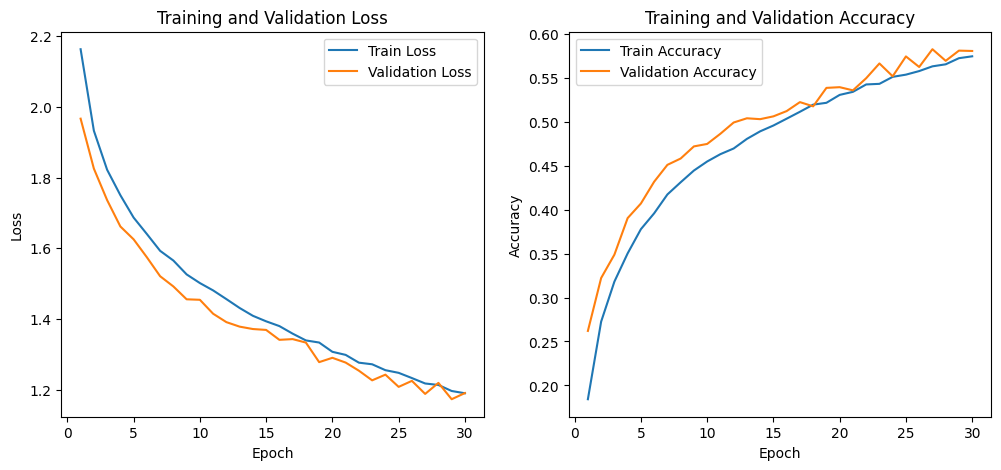

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import shufflenet_v2_x1_0
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

# 检查是否有 GPU 并设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = shufflenet_v2_x1_0(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc


num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


min_len = min(len(train_losses), len(val_losses))
train_losses = train_losses[:min_len]
val_losses = val_losses[:min_len]


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, min_len + 1), train_losses, label='Train Loss')
plt.plot(range(1, min_len + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

min_len_acc = min(len(train_accuracies), len(val_accuracies))
train_accuracies = train_accuracies[:min_len_acc]
val_accuracies = val_accuracies[:min_len_acc]

plt.subplot(1, 2, 2)
plt.plot(range(1, min_len_acc + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, min_len_acc + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Train Loss: 1.7918, Train Accuracy: 0.3453, Val Loss: 1.5093, Val Accuracy: 0.4506
Epoch [2/30], Train Loss: 1.4168, Train Accuracy: 0.4920, Val Loss: 1.3506, Val Accuracy: 0.5124
Epoch [3/30], Train Loss: 1.2563, Train Accuracy: 0.5531, Val Loss: 1.2088, Val Accuracy: 0.5706
Epoch [4/30], Train Loss: 1.1488, Train Accuracy: 0.5930, Val Loss: 1.1515, Val Accuracy: 0.5948
Epoch [5/30], Train Loss: 1.0547, Train Accuracy: 0.6297, Val Loss: 1.0870, Val Accuracy: 0.6134
Epoch [6/30], Train Loss: 0.9681, Train Accuracy: 0.6622, Val Loss: 1.0302, Val Accuracy: 0.6377
Epoch [7/30], Train Loss: 0.9067, Train Accuracy: 0.6831, Val Loss: 1.0026, Val Accuracy: 0.6445
Epoch [8/30], Train Loss: 0.8382, Train Accuracy: 0.7054, Val Loss: 0.9571, Val Accuracy: 0.6669
Epoch [9/30], Train Loss: 0.7809, Train Accuracy: 0.7262, Val Loss: 0.9415, Val Accuracy: 0.6736
Epoch [10/30], Train Loss: 0.728

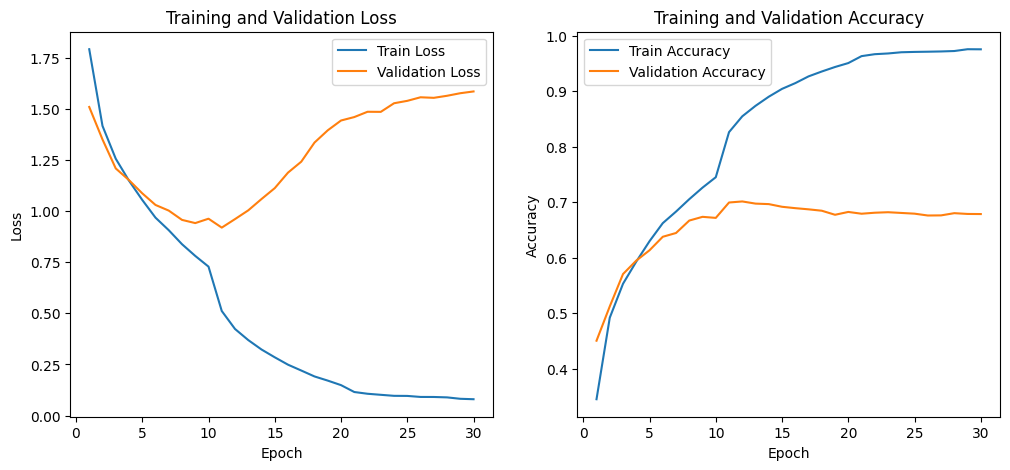

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import shufflenet_v2_x1_0
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


model = shufflenet_v2_x1_0(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # 使用权重衰减
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # 使用学习率调度器


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    

    scheduler.step()


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


c:\Users\32987\OneDrive\文档\DLF\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Train Loss: 1.7555, Train Accuracy: 0.3593, Val Loss: 1.4525, Val Accuracy: 0.4807
Epoch [2/30], Train Loss: 1.3756, Train Accuracy: 0.5056, Val Loss: 1.2868, Val Accuracy: 0.5363
Epoch [3/30], Train Loss: 1.2193, Train Accuracy: 0.5660, Val Loss: 1.1818, Val Accuracy: 0.5750
Epoch [4/30], Train Loss: 1.1054, Train Accuracy: 0.6095, Val Loss: 1.1404, Val Accuracy: 0.5996
Epoch [5/30], Train Loss: 1.0183, Train Accuracy: 0.6446, Val Loss: 1.0607, Val Accuracy: 0.6283
Epoch [6/30], Train Loss: 0.9491, Train Accuracy: 0.6713, Val Loss: 1.0239, Val Accuracy: 0.6434
Epoch [7/30], Train Loss: 0.8914, Train Accuracy: 0.6893, Val Loss: 0.9647, Val Accuracy: 0.6635
Epoch [8/30], Train Loss: 0.8362, Train Accuracy: 0.7084, Val Loss: 0.9335, Val Accuracy: 0.6787
Epoch [9/30], Train Loss: 0.7893, Train Accuracy: 0.7267, Val Loss: 0.9247, Val Accuracy: 0.6824
Epoch [10/30], Train Loss: 0.7529, Train Accuracy: 0.7399, Val Loss: 0.8964, Val Accuracy: 0.6874
Epoch [11/30], Train Loss: 0.

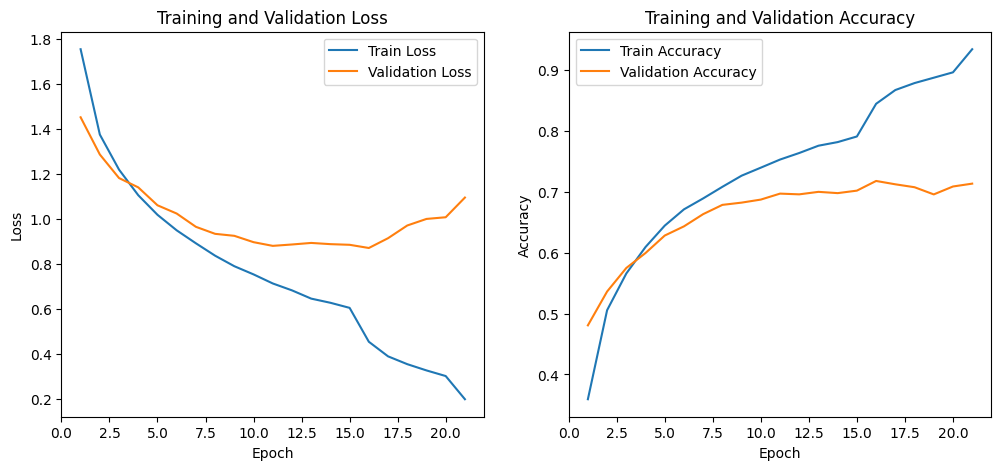

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import shufflenet_v2_x1_0
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = shufflenet_v2_x1_0(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


early_stop_patience = 5  
best_val_loss = float('inf')
early_stop_counter = 0


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc


num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    
   
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("提前停止: 验证损失未改善")
            break


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Train Loss: 2.0088, Train Accuracy: 0.2502, Val Loss: 1.7630, Val Accuracy: 0.3488
Epoch [2/30], Train Loss: 1.7052, Train Accuracy: 0.3672, Val Loss: 1.5907, Val Accuracy: 0.4091
Epoch [3/30], Train Loss: 1.5613, Train Accuracy: 0.4266, Val Loss: 1.4902, Val Accuracy: 0.4536
Epoch [4/30], Train Loss: 1.4597, Train Accuracy: 0.4715, Val Loss: 1.4200, Val Accuracy: 0.4824
Epoch [5/30], Train Loss: 1.3771, Train Accuracy: 0.5029, Val Loss: 1.3089, Val Accuracy: 0.5276
Epoch [6/30], Train Loss: 1.3088, Train Accuracy: 0.5304, Val Loss: 1.2590, Val Accuracy: 0.5451
Epoch [7/30], Train Loss: 1.2395, Train Accuracy: 0.5574, Val Loss: 1.1944, Val Accuracy: 0.5736
Epoch [8/30], Train Loss: 1.1846, Train Accuracy: 0.5805, Val Loss: 1.1395, Val Accuracy: 0.5924
Epoch [9/30], Train Loss: 1.1362, Train Accuracy: 0.5974, Val Loss: 1.0990, Val Accuracy: 0.6071
Epoch [10/30], Train Loss: 1.089

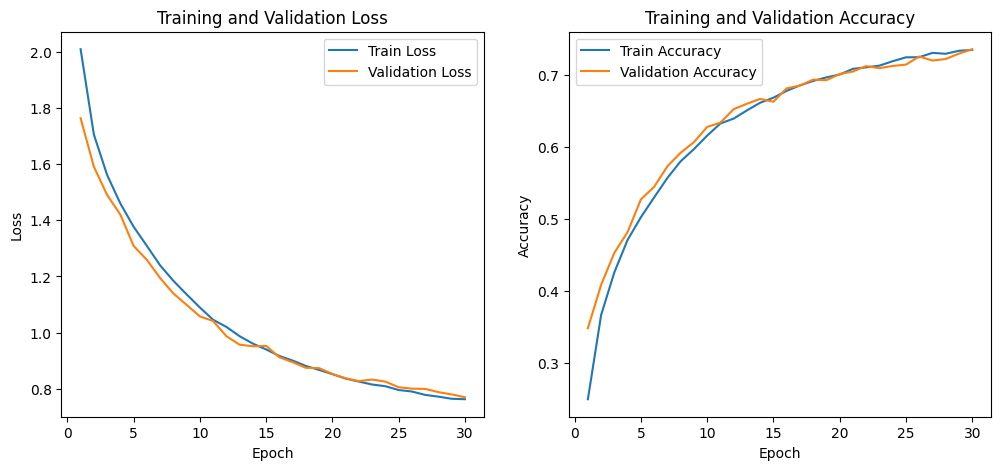

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import shufflenet_v2_x1_0
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


model = shufflenet_v2_x1_0(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc


num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
early_stop_patience = 5
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    
 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("提前停止: 验证损失未改善")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


Using device: cuda
Epoch [1/50], Train Loss: 2.0797, Train Accuracy: 0.2207, Val Loss: 1.8908, Val Accuracy: 0.2968
Epoch [2/50], Train Loss: 1.8091, Train Accuracy: 0.3265, Val Loss: 1.6887, Val Accuracy: 0.3679
Epoch [3/50], Train Loss: 1.6679, Train Accuracy: 0.3791, Val Loss: 1.5746, Val Accuracy: 0.4187
Epoch [4/50], Train Loss: 1.5593, Train Accuracy: 0.4280, Val Loss: 1.4814, Val Accuracy: 0.4591
Epoch [5/50], Train Loss: 1.4813, Train Accuracy: 0.4560, Val Loss: 1.4227, Val Accuracy: 0.4782
Epoch [6/50], Train Loss: 1.4101, Train Accuracy: 0.4874, Val Loss: 1.3555, Val Accuracy: 0.5064
Epoch [7/50], Train Loss: 1.3574, Train Accuracy: 0.5072, Val Loss: 1.2952, Val Accuracy: 0.5312
Epoch [8/50], Train Loss: 1.3052, Train Accuracy: 0.5315, Val Loss: 1.2562, Val Accuracy: 0.5433
Epoch [9/50], Train Loss: 1.2545, Train Accuracy: 0.5500, Val Loss: 1.2168, Val Accuracy: 0.5659
Epoch [10/50], Train Loss: 1.2133, Train Accuracy: 0.5663, Val Loss: 1.1800, Val Accuracy: 0.5796
Epoch [11/

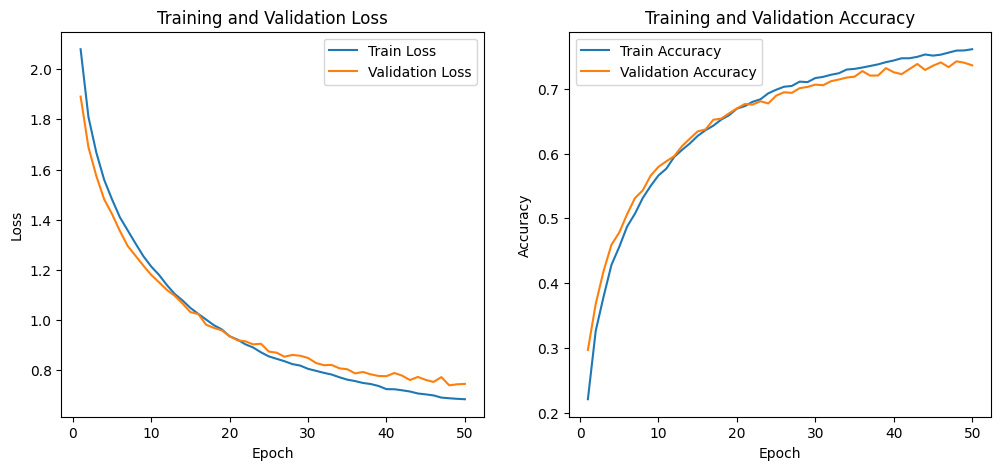

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import shufflenet_v2_x1_0
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = shufflenet_v2_x1_0(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0005)  


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc


early_stopping_patience = 5
best_val_loss = np.inf
patience_counter = 0

num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    
    # Early Stopping 判断
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered. Stopping training.")
        break


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


Using device: cuda
Epoch [1/50], Train Loss: 2.2067, Train Accuracy: 0.1752, Val Loss: 2.0413, Val Accuracy: 0.2376
Epoch [2/50], Train Loss: 1.9773, Train Accuracy: 0.2669, Val Loss: 1.8562, Val Accuracy: 0.3138
Epoch [3/50], Train Loss: 1.8387, Train Accuracy: 0.3217, Val Loss: 1.7526, Val Accuracy: 0.3480
Epoch [4/50], Train Loss: 1.7436, Train Accuracy: 0.3592, Val Loss: 1.6670, Val Accuracy: 0.3910
Epoch [5/50], Train Loss: 1.6653, Train Accuracy: 0.3926, Val Loss: 1.5916, Val Accuracy: 0.4194
Epoch [6/50], Train Loss: 1.5998, Train Accuracy: 0.4171, Val Loss: 1.5240, Val Accuracy: 0.4434
Epoch [7/50], Train Loss: 1.5400, Train Accuracy: 0.4394, Val Loss: 1.4854, Val Accuracy: 0.4610
Epoch [8/50], Train Loss: 1.4958, Train Accuracy: 0.4602, Val Loss: 1.4354, Val Accuracy: 0.4800
Epoch [9/50], Train Loss: 1.4589, Train Accuracy: 0.4739, Val Loss: 1.3975, Val Accuracy: 0.4914
Epoch [10/50], Train Loss: 1.4108, Train Accuracy: 0.4936, Val Loss: 1.3433, Val Accuracy: 0.5130
Epoch [11/

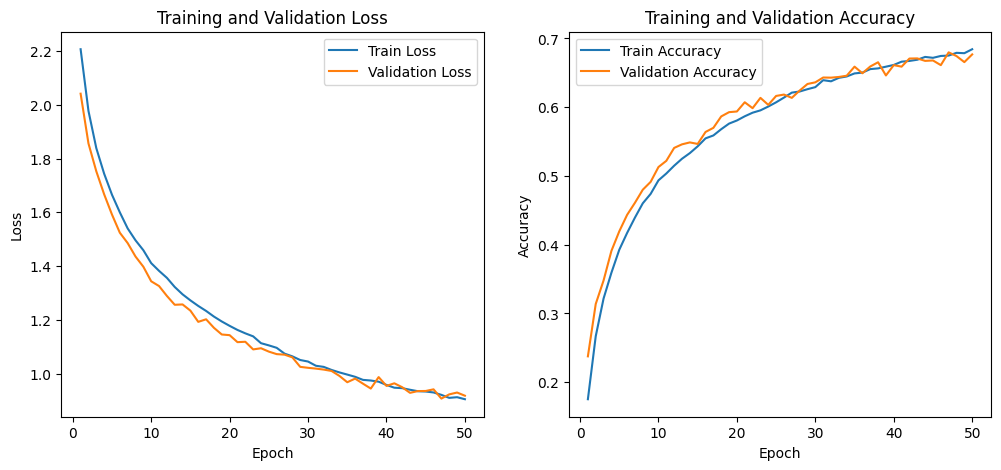

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import shufflenet_v2_x1_0
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

train_dataset = CIFAR10Dataset(data_file='train_data.pkl', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR10Dataset(data_file='val_data.pkl', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model = shufflenet_v2_x1_0(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0005)  


early_stopping_patience = 5
best_val_loss = np.inf
patience_counter = 0


num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
   
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = correct_val / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_shufflenet_model.pth')  
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered. Stopping training.")
        break


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


## Test

Files already downloaded and verified


c:\Users\32987\OneDrive\文档\DLF\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\32987\OneDrive\文档\DLF\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\32987\AppData\Local\Temp\ipykernel_41304\4275387175.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `wei

MobileNetV2 Test Accuracy: 0.7443
ShuffleNetV2 Test Accuracy: 0.1000
ResNet18 Test Accuracy: 0.0646

Error Analysis for MobileNetV2

Most common misclassifications:
Predicted: cat, Actual: dog, Count: 170
Predicted: dog, Actual: cat, Count: 141
Predicted: airplane, Actual: bird, Count: 115
Predicted: horse, Actual: deer, Count: 100
Predicted: horse, Actual: dog, Count: 99


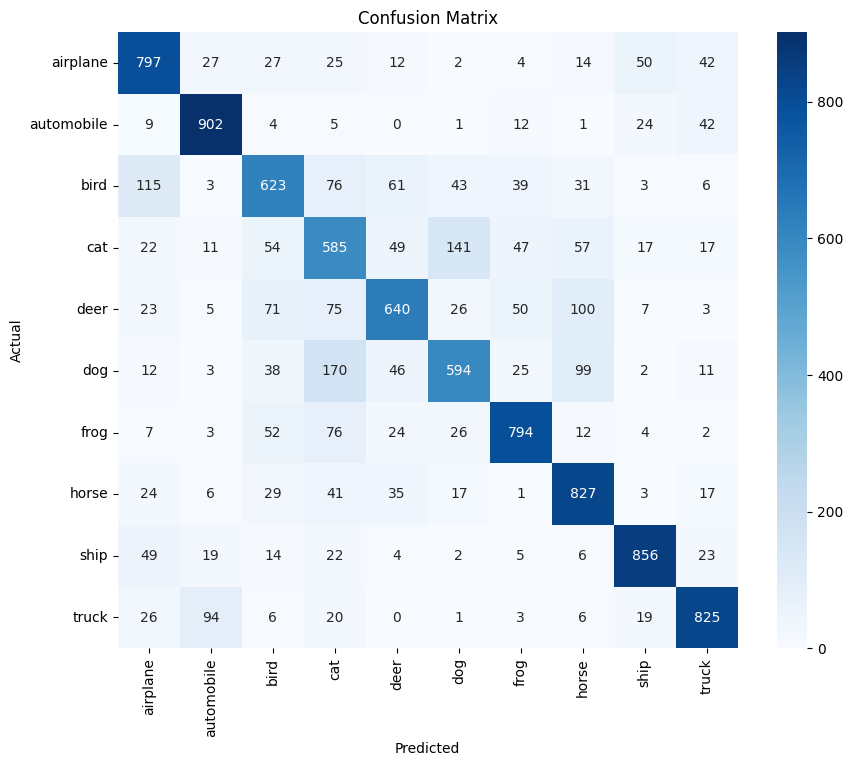


Top 5 Most Confused Class Pairs:
dog vs cat: 170 times
cat vs dog: 141 times
bird vs airplane: 115 times
deer vs horse: 100 times
dog vs horse: 99 times

Error Analysis for ShuffleNetV2

Most common misclassifications:
Predicted: automobile, Actual: cat, Count: 1000
Predicted: automobile, Actual: ship, Count: 1000
Predicted: automobile, Actual: airplane, Count: 1000
Predicted: automobile, Actual: frog, Count: 1000
Predicted: automobile, Actual: truck, Count: 1000


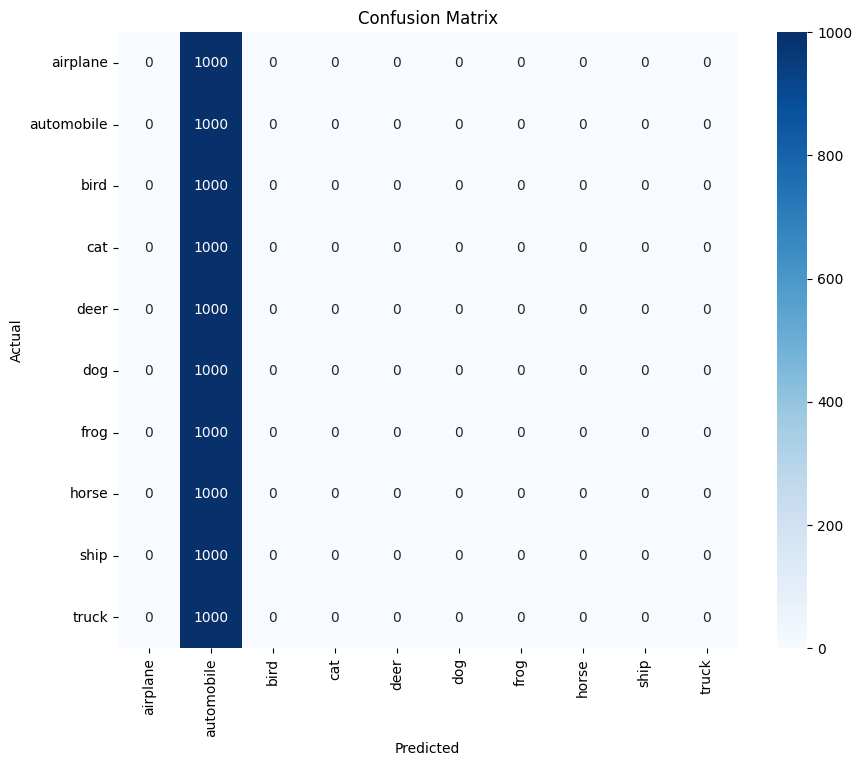


Top 5 Most Confused Class Pairs:
airplane vs automobile: 1000 times
bird vs automobile: 1000 times
cat vs automobile: 1000 times
deer vs automobile: 1000 times
dog vs automobile: 1000 times

Error Analysis for ResNet18

Most common misclassifications:
Predicted: bird, Actual: automobile, Count: 827
Predicted: truck, Actual: airplane, Count: 640
Predicted: bird, Actual: dog, Count: 631
Predicted: bird, Actual: truck, Count: 532
Predicted: dog, Actual: ship, Count: 503


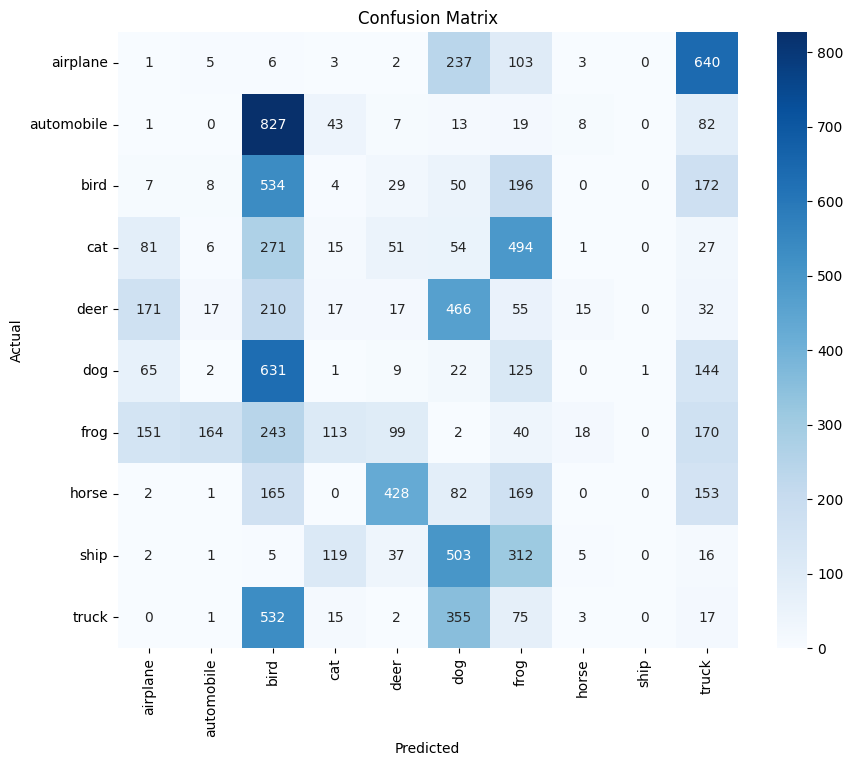


Top 5 Most Confused Class Pairs:
automobile vs bird: 827 times
airplane vs truck: 640 times
dog vs bird: 631 times
truck vs bird: 532 times
ship vs dog: 503 times


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import pandas as pd


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


test_dataset = CIFAR10Dataset(root='./test_batch', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def load_model(model_path, model_class):
    model = model_class()
   
    state_dict = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    model.eval()
    return model


class MobileNetV2Custom(nn.Module):
    def __init__(self):
        super(MobileNetV2Custom, self).__init__()
        self.model = models.mobilenet_v2(pretrained=False)
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 10)
        )
    
    def forward(self, x):
        return self.model(x)

class ShuffleNetV2Custom(nn.Module):
    def __init__(self):
        super(ShuffleNetV2Custom, self).__init__()
        self.model = models.shufflenet_v2_x1_0(pretrained=False)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 10)
    
    def forward(self, x):
        return self.model(x)

class ResNet18Custom(nn.Module):
    def __init__(self):
        super(ResNet18Custom, self).__init__()
        self.model = models.resnet18(pretrained=False)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 10)
    
    def forward(self, x):
        return self.model(x)


def test_model(model, test_loader, device):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    return accuracy, all_preds, all_labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_paths = {
    "MobileNetV2": "best_mobilenet_model.pth",
    "ShuffleNetV2": "best_shufflenet_model.pth",
    "ResNet18": "final_resnet18_model.pth"
}
model_classes = {
    "MobileNetV2": MobileNetV2Custom,
    "ShuffleNetV2": ShuffleNetV2Custom,
    "ResNet18": ResNet18Custom
}

results = {}
for model_name, model_path in model_paths.items():
    model = load_model(model_path, model_classes[model_name])
    accuracy, preds, labels = test_model(model, test_loader, device)
    results[model_name] = {"accuracy": accuracy, "preds": preds, "labels": labels}
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


def error_analysis(preds, labels, classes):
   
    errors = [(p, l) for p, l in zip(preds, labels) if p != l]
    error_counts = Counter(errors)
    most_common_errors = error_counts.most_common(5)
    print("\nMost common misclassifications:")
    for (pred, label), count in most_common_errors:
        print(f"Predicted: {classes[pred]}, Actual: {classes[label]}, Count: {count}")
    
   
    confusion_matrix = np.zeros((10, 10), dtype=int)
    for p, l in zip(preds, labels):
        confusion_matrix[l][p] += 1
    
   
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
   
    most_confused_pairs = [(classes[i], classes[j], confusion_matrix[i][j]) for i in range(10) for j in range(10) if i != j]
    most_confused_pairs = sorted(most_confused_pairs, key=lambda x: x[2], reverse=True)[:5]
    
    print("\nTop 5 Most Confused Class Pairs:")
    for class1, class2, count in most_confused_pairs:
        print(f"{class1} vs {class2}: {count} times")


for model_name, result in results.items():
    print(f"\nError Analysis for {model_name}")
    error_analysis(result["preds"], result["labels"], classes)
